# Identifying spam e-mails with neural networks

A common use for binary classification is sorting spam e-mails from legitimate e-mails. It's not difficult to build a neural network that classifies text. Let's use Keras to build a binary classifier for e-mails, train it with a collection of e-mails labeled with 0s (for not spam) and 1s (for spam), and then run a few e-mails through it to see how well it performs.

## Load and prepare the data

The first step is to load the dataset and prepare it for use in deep learning. We'll use Keras's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to vectorize the text in the training e-mails, and we'll get some help from the [Natural Language Toolkit](https://www.nltk.org/) for removing stop words.

In [1]:
import pandas as pd

df = pd.read_csv('Data/ham-spam.csv')
df = df.sample(frac=1, random_state=0)
df.head()

,IsSpam,Text
993,1,utf date course utf diminish weight our table...
859,1,utf any drugs eur utf for dose have you ever ...
298,0,expert finderhttps expertfinder enron com
553,1,and courtiers ministerssubsegment founded res...
672,1,for our clients fargo dear customer have updat...


Find out how many rows the dataset contains and confirm that there are no missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 993 to 684
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   IsSpam  1000 non-null   int64 
 1   Text    1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


Remove duplicate rows from the dataset and check for balance.

In [3]:
df = df.drop_duplicates()
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        499    499  cdwrlouise spoke with mark believe getting lit...    1
1        500    500  new account activationdear applicant your appl...    1

Create a feature column *x* containing the text in the "Text" column with stopwords removed, and a label column *y*.

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
    
x = df.apply(lambda row: remove_stop_words(row['Text']), axis=1)
y = df['IsSpam']

Tokenize the text and create padded sequences from it.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
max_words = 10000
max_length = 500
 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

## Train a neural network to identify spam

Create a neural network containing an [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) layer for converting sequences into arrays of word vectors and a [`Dense`](https://keras.io/api/layers/core_layers/dense/) layer for classifying arrays of word vectors.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
 
model = Sequential() 
model.add(Embedding(max_words, 32, input_length=max_length)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 128)               2048128   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,368,257
Trainable params: 2,368,257
Non-trainable params: 0
_________________________________________________________________


Train the network.

In [7]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5
40/40 [==============================] - 1s 10ms/step - loss: 0.6413 - accuracy: 0.6345 - val_loss: 0.5854 - val_accuracy: 0.6450
Epoch 2/5
40/40 [==============================] - 0s 8ms/step - loss: 0.3432 - accuracy: 0.8773 - val_loss: 0.2495 - val_accuracy: 0.9500
Epoch 3/5
40/40 [==============================] - 0s 8ms/step - loss: 0.0838 - accuracy: 0.9850 - val_loss: 0.1794 - val_accuracy: 0.9150
Epoch 4/5
40/40 [==============================] - 0s 8ms/step - loss: 0.0350 - accuracy: 0.9900 - val_loss: 0.1406 - val_accuracy: 0.9450
Epoch 5/5
40/40 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 0.9962 - val_loss: 0.1225 - val_accuracy: 0.9650


Chart the training and validation accuracy for each epoch.

[]

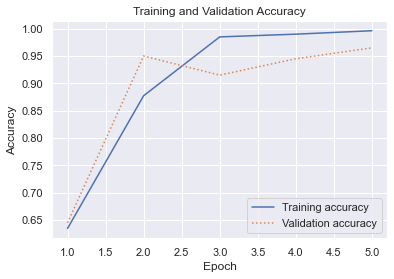

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Train a convolutional neural network to identify spam

Convolutional neural networks (CNNs) are primarily used to classify images, but they can be helpful for text classification, too. One advantage to a CNN is that it can recognize word patterns and factor them into its predictions rather than treat words independently. Let's train a CNN and see if it can achieve a higher validation accuracy than a conventional neural network.

In [9]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
 
model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary(line_length=100)

Model: "sequential_1"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 embedding_1 (Embedding)                     (None, 500, 32)                         320000         
                                                                                                    
 conv1d (Conv1D)                             (None, 494, 32)                         7200           
                                                                                                    
 max_pooling1d (MaxPooling1D)                (None, 98, 32)                          0              
                                                                                                    
 conv1d_1 (Conv1D)                           (None, 92, 32)                          7200           
                                                                     

Train the network.

In [10]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5
40/40 [==============================] - 1s 14ms/step - loss: 0.6786 - accuracy: 0.5920 - val_loss: 0.6532 - val_accuracy: 0.6300
Epoch 2/5
40/40 [==============================] - 0s 10ms/step - loss: 0.5236 - accuracy: 0.7547 - val_loss: 0.3668 - val_accuracy: 0.8750
Epoch 3/5
40/40 [==============================] - 0s 9ms/step - loss: 0.1794 - accuracy: 0.9499 - val_loss: 0.1546 - val_accuracy: 0.9500
Epoch 4/5
40/40 [==============================] - 0s 10ms/step - loss: 0.0589 - accuracy: 0.9800 - val_loss: 0.1165 - val_accuracy: 0.9600
Epoch 5/5
40/40 [==============================] - 0s 10ms/step - loss: 0.0344 - accuracy: 0.9875 - val_loss: 0.1085 - val_accuracy: 0.9700


Chart the training and validation accuracy for each epoch.

[]

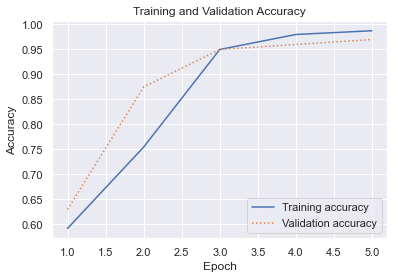

In [11]:
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Use the model to classify e-mails

Now let's see how the model classifies some sample e-mails. We'll start with a message that is not spam. The model's `predict` method predicts the probability that the input belongs to the positive class (spam).

In [12]:
cleaned_text = remove_stop_words('Can you attend a code review on Tuesday? ' +
                                 'Need to make sure the logic is rock solid.')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.34674406

Now test the model with a spam message.

In [13]:
cleaned_text = remove_stop_words('Why pay more for expensive meds when ' + 
                                 'you can order them online and save $$$?')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.82803607

What did the network predict for the first e-mail? What about the second? Do you agree with the predictions? Remember that a number close to 0.0 indicates that the e-mail is not spam, while a number close to 1.0 indicates that it is.